In [181]:
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd 

In [182]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj


def smoSimple(X_data,Y_data,C,toler,maxIter):
    X_train = mat(X_data)
    Y_train = mat(Y_data).transpose()
    b = 0
    m,n = data.shape
    iter = 0
    #alpha值，初始化为0，每一个样本都有一个alpha值
    alphas = mat(zeros((m,1)))
    while(iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #f(x)=w*x+b  w=sum(alpha*y*x)  这里的sum表示所有的样本 例如有N个样本则是N个样本的alpha*y*x相加
            #-> f(x)=sum(alpha * y * x)*xi
            fxi = float(multiply(alphas,Y_train).T*(X_train*X_train[i,:].T)) + b
            #误差
            Ei = fxi - float(Y_train[i])
            #KTT : 0 <= alpha <= C toler为容错参数，当超过容错参数同时alpha在约束条件内才继续优化alpha，
            #Y_train[i]*Ei < -toler表示alpha需要增大，同理Y_train[i]*Ei > toler表示alpha需要缩小
            if ((Y_train[i]*Ei < -toler) and (alphas[i]< C)) or ((Y_train[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选取另外一个样本j
                j = selectJrand(i,m)
                fXj = float(multiply(alphas,Y_train).T*(X_train*X_train[j,:].T)) + b
                Ej = fXj - float(Y_train[j])
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #由KTT:sum(alphas*y) = 0
                #当i与j的y同号时相当于alphas[i] + alphas[j] = A(常数) 
                #异号时相当于alphas[i] - alphas[j] = A
                #同时必须满足 0 <= alpha <= C 
                #则分别求出上下界L H 如果上下界相同，则alpha处于边界 直接跳过
                if (Y_train[i] != Y_train[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
#                     print "L==H";
                    continue
                #由sum(y[i]*alpha[i]) = 0 将alpha[j]由alpha[i]表示带入目标函数 可以得到alpha[2]的一元二次方程，求导使其为0可以得到极值点
                #最终alpha[j]=alpha[j]_old + y[j](Ei-Ej)/(K11+K22-2K12) K11 = (X[i].X[j])
                #这里eta为2K12 - K11 - K22
                eta = 2.0 * X_train[i,:]*X_train[j,:].T - X_train[i,:]*X_train[i,:].T - X_train[j,:]*X_train[j,:].T
                if eta >= 0: print "eta>=0"; continue
                alphas[j] -= Y_train[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                #如果变化率太小则跳出
                if (abs(alphas[j] - alphaJold) < 0.00001):
#                     print "j not moving enough";
                    continue
                #由于Y为+1 -1分类 所以这里可以写成Y[i]*Y[j]
                #alphas[i] = -delta[j]*Y[j]/Y[i]   delta[J] = alpha[j]_new - alpha[j]_old
                alphas[i] += Y_train[j]*Y_train[i]*(alphaJold - alphas[j])
                #取一个alpha[k]使得0<alpha<C(处于间隔边界) b=y[k] - sum(alpha[i]*y[i]*(x[i].x[j]))
                #变成如下形式：如果alpha[1] 在0到C ,b1_new = -E1-y1*K11(alpha1_new-alpha1_old)-y2*K21(alpha2_new-alpha2_old) + b_old
                b1 = b - Ei- Y_train[i]*(alphas[i]-alphaIold)*X_train[i,:]*X_train[i,:].T - Y_train[j]*(alphas[j]-alphaJold)*X_train[i,:]*X_train[j,:].T
                b2 = b - Ej- Y_train[i]*(alphas[i]-alphaIold)*X_train[i,:]*X_train[j,:].T - Y_train[j]*(alphas[j]-alphaJold)*X_train[j,:]*X_train[j,:].T
                #如果alpha1 和alpha2都不满足条件则取b1+b2/2
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
#                 print "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
#         print "iteration number: %d" % iter
#     w = calcWs(alphas,X_train,Y_train)
    return b,alphas
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(X)
    w = zeros((n,1))
#     print(X[1,:].T)
#     print(multiply(alphas[1]*labelMat[1])*X[1,:].T)
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w
def predict(dataIn,w,b):
    
    y = mat(dataIn)*mat(w)+b
    return y
    

In [183]:
data,label = loadDataSet("testSet.txt")
# plt.scatter(data[:,0],data[:,1])
data = np.array(data)
label = np.array(label)

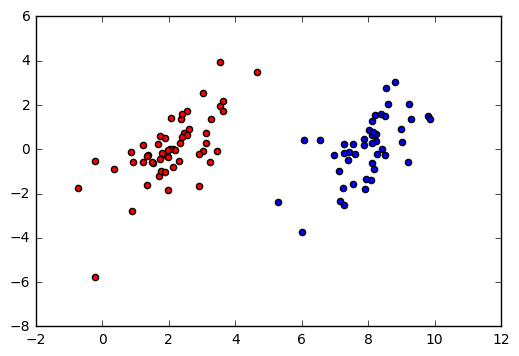

In [184]:
neg = data[np.where(label==-1)]
pos = data[np.where(label==1)]
plt.scatter(neg[:,0],neg[:,1],c= "red")
plt.scatter(pos[:,0],pos[:,1],c= "blue")
plt.show()

In [185]:
m = data.shape[0]

In [186]:
msk = np.random.rand(len(data)) < 0.8

trainData = data[msk]
trainLabel = label[msk]

testData = data[~msk]
testLabel = label[~msk]

In [187]:
trainData.shape

(81, 2)

In [188]:
b,alphas = smoSimple(data,label,0.6,0.001,50)
w = calcWs(alphas,data,label)

In [189]:
predictResult = predict(data,w,b)
predictResult = np.array(predictResult)

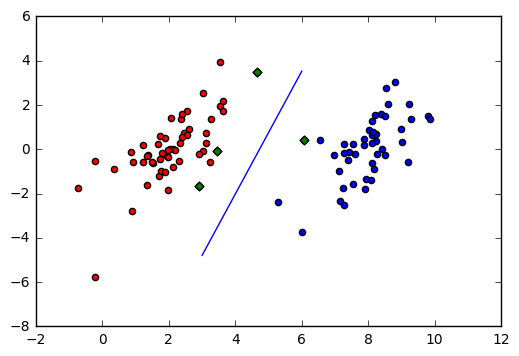

In [190]:
neg = data[np.where(predictResult[:,0]<=0)]
pos = data[np.where(predictResult[:,0]>=0)]

plt.scatter(neg[:,0],neg[:,1],c= "red")
plt.scatter(pos[:,0],pos[:,1],c= "blue")
x = np.array(np.linspace(3, 6, 100))
y = (-b-w[0]*x)/w[1]
plt.plot(x,y.T)

#绿色的为支持向量
alphas = np.array(alphas)
plt.scatter(data[np.where(alphas[:,0] > 0)][:,0],data[np.where(alphas[:,0] > 0)][:,1],c="green",marker="D")
plt.show()
